In [1]:
#PIP INSTALLATION
print('---1---')
%pip install pandas
print('---2---')
%pip install seaborn
print('---3---')
%pip install scikit-learn
print('---4---')
%pip install catboost
print('---5---')
%pip install ipywidgets
print('---6---')
%pip install pandas openpyxl
print('---7---')
%pip install bayesian-optimization
print('---8---')
%pip install fsspec
print('---9---')
%pip install huggingface_hub
print('---10---')
%pip install datasets


---1---


Note: you may need to restart the kernel to use updated packages.
---2---



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
---3---



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
---4---



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
---5---



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
---6---



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
---7---



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
---8---



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
---9---



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
---10---



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from catboost import CatBoostClassifier, Pool

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    confusion_matrix
)
from sklearn.model_selection import StratifiedKFold
from bayes_opt import BayesianOptimization
from typing import List, Optional
from sklearn.model_selection import train_test_split


from datasets import load_dataset


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
dataset_path = None
algorithm = 'catboost'

In [4]:
# Parameters
dataset_path = "temp\\eac12fd1-c872-46c5-b1a0-9466ecbd6ca7.csv"
algorithm = "bayesian"
model_output_path = "saved_models/Bayesian_Opt_Catboost_1742120539.cbm"


In [5]:
df = pd.read_csv(dataset_path)
X = df.drop(columns=['readmitted'])
y = df['readmitted'].values

In [6]:
cat_features = X.select_dtypes(include=['object']).columns.tolist()
X[cat_features] = X[cat_features].astype(str)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Final CatboostBayesianOptimzer

In [8]:
gpu_available = "NVIDIA_VISIBLE_DEVICES" in os.environ or "CUDA_VISIBLE_DEVICES" in os.environ
task_type = 'GPU' if gpu_available else 'CPU'

class CatBoostBayesianOptimizer:
    def __init__(self, X_train, y_train, cat_features, eval_metric, n_splits, random_state=42, gpu_id=0):
        self.X_train = X_train
        self.y_train = y_train
        self.cat_features = cat_features
        self.eval_metric = eval_metric
        self.n_splits = n_splits
        self.random_state = random_state
        self.gpu_id = gpu_id
        
        self._validate_inputs()
        
    def _validate_inputs(self):
        if not isinstance(self.X_train, pd.DataFrame):
            raise TypeError("X_train must be a pandas DataFrame")
        
        if not all(col in self.X_train.columns for col in self.cat_features):
            raise ValueError("Some categorical features not found in X_train")
            
        if self.eval_metric not in ['f1', 'auc', 'accuracy']:
            raise ValueError("eval_metric must be one of: 'f1', 'auc', 'accuracy'")
    
    #This is also hyperparameters for catboost but it cant be applied with bayesian optimization
    def _get_base_params(self, custom_params=None):
        """Get base CatBoost parameters"""
        base_params = {
            'random_state': self.random_state,
            'verbose': False,
            'task_type': task_type,
            'devices': f'{self.gpu_id}' if task_type == 'GPU' else None,
            'loss_function': 'Logloss',
            'eval_metric': 'Logloss'
        }
        return {**base_params, **custom_params} if custom_params else base_params
    
    def _get_metric_score(self, y_true, y_pred, y_prob=None):
        if self.eval_metric == 'f1':
            return f1_score(y_true, y_pred, average='weighted')
        elif self.eval_metric == 'auc':
            if len(np.unique(y_true)) > 2:
                return roc_auc_score(y_true, y_prob, multi_class='ovr')
            return roc_auc_score(y_true, y_prob[:, 1])
        return accuracy_score(y_true, y_pred)
    
    def _evaluate_model(self, model, X_val, y_val):
        """Evaluate model performance"""
        if self.eval_metric == 'auc':
            y_prob = model.predict_proba(X_val)
            return self._get_metric_score(y_val, np.argmax(y_prob, axis=1), y_prob)
        y_pred = model.predict(X_val)
        return self._get_metric_score(y_val, y_pred)
        
    #This is the 1st step to add another Parameters... you can add in here
    def _objective(self, iterations, learning_rate, depth, l2_leaf_reg, border_count):
        try:
            params = self._get_base_params({
                'iterations': int(iterations),
                'learning_rate': float(learning_rate),
                'depth': int(depth),
                'l2_leaf_reg': float(l2_leaf_reg),
                'border_count': int(border_count),
            })
            
            X_train, X_val, y_train, y_val = train_test_split(
                self.X_train, self.y_train,
                test_size=0.2,
                random_state=self.random_state,
                stratify=self.y_train
            )
            
            train_pool = Pool(X_train, label=y_train, cat_features=self.cat_features)
            val_pool = Pool(X_val, label=y_val, cat_features=self.cat_features)
            
            model = CatBoostClassifier(**params)
            model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=False)
            
            return self._evaluate_model(model, X_val, y_val)
                
        except Exception as e:
            print(f"Error in optimization: {str(e)}")
            return 0.0
        
    def optimize(self, n_iter=50, n_init_points=10):
        if n_iter <= n_init_points:
            raise ValueError("n_iter must be greater than n_init_points")
        
        #After adding the parameters you set the value for the parameters
        pbounds = {
            'iterations': (800, 1000),
            'learning_rate': (0.025, 0.035),
            'depth': (7, 9),
            'l2_leaf_reg': (3.0, 5.0),
            'border_count': (60, 85),
        }
        
        optimizer = BayesianOptimization(
            f=self._objective,
            pbounds=pbounds,
            random_state=self.random_state
        )
        
        optimizer.maximize(init_points=n_init_points, n_iter=n_iter)
        
        best_params = optimizer.max['params']
        print("\nBest parameters found:")
        for param, value in best_params.items():
            if param in ['depth', 'border_count', 'iterations']:
                print(f"{param}: {int(value)}")
            else:
                print(f"{param}: {value:.4f}")
        print(f"\nBest CV {self.eval_metric} score: {optimizer.max['target']:.4f}")
    
        return best_params
    
    def Final_model(self, best_params):
        """Use SKCV to evaluate and choose the best iteration count, then train a final model"""
        # Prepare cross-validation folds
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        fold_scores = []
        best_iterations = []
        
        # Create base parameters from best Bayesian optimization results
        model_params = self._get_base_params({
            'iterations': int(best_params['iterations']),
            'learning_rate': best_params['learning_rate'],
            'depth': int(best_params['depth']),
            'l2_leaf_reg': best_params['l2_leaf_reg'],
            'border_count': int(best_params['border_count'])
        })
        
        print(f"\nPerforming {self.n_splits}-fold CV to determine optimal iterations...")
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(self.X_train, self.y_train), 1):
            X_fold_train = self.X_train.iloc[train_idx]
            y_fold_train = self.y_train[train_idx]
            X_fold_val = self.X_train.iloc[val_idx]
            y_fold_val = self.y_train[val_idx]
            
            train_pool = Pool(X_fold_train, label=y_fold_train, cat_features=self.cat_features)
            val_pool = Pool(X_fold_val, label=y_fold_val, cat_features=self.cat_features)
            
            # Train model with early stopping
            model = CatBoostClassifier(**model_params)

            #You can change the final model here
            model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=100)
            
            # Store the best iteration number
            best_iterations.append(model.get_best_iteration())
            
            # Evaluate on validation set
            score = self._evaluate_model(model, X_fold_val, y_fold_val)
            print(f"Fold {fold} {self.eval_metric} score: {score:.4f}, Best iteration: {model.get_best_iteration()}")
            
            fold_scores.append(score)
        
        mean_score = np.mean(fold_scores)
        std_score = np.std(fold_scores)
        
        # Calculate the median best iteration across folds
        optimal_iterations = int(np.median(best_iterations)) if np.std(best_iterations) > 5 else int(np.mean(best_iterations))
        
        print(f"\nCV Results:")
        print(f"Average {self.eval_metric} score: {mean_score:.4f} ± {std_score:.4f}")
        print(f"Optimal iterations (median across folds): {optimal_iterations}")
        
        # Train final model on split dataset with validation set
        X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
            self.X_train, self.y_train,
            test_size=0.1,  # 20% validation set
            random_state=self.random_state,
            stratify=self.y_train
        )
        
        train_pool = Pool(X_train_final, label=y_train_final, cat_features=self.cat_features)
        val_pool = Pool(X_val_final, label=y_val_final, cat_features=self.cat_features)
        
        final_model_params = model_params.copy()
        final_model_params['iterations'] = optimal_iterations
        
        print(f"\nTraining final model on training dataset with {optimal_iterations} iterations...")
        
        final_model = CatBoostClassifier(**final_model_params)
        final_model.fit(train_pool, eval_set=val_pool, verbose=100)
        
        if False:  # Set to True if you want the full retrain without validation
            print("Retraining on full dataset without validation...")
            full_model_params = final_model_params.copy()
            full_train_pool = Pool(self.X_train, label=self.y_train, cat_features=self.cat_features)
            full_model = CatBoostClassifier(**full_model_params)
            full_model.fit(full_train_pool, verbose=100)
            return full_model, mean_score, std_score
        
        return final_model, mean_score, std_score

    def save_model(self, model, filepath):
        """Save the trained CatBoost model to disk"""
        try:
            model.save_model(filepath)
            print(f"Model successfully saved to {filepath}")
            return True
        except Exception as e:
            print(f"Error saving model: {str(e)}")
            return False

    

In [9]:
class FinalModelEvaluator:
    def __init__(
        self,
        model,
        X_train: pd.DataFrame,
        y_train: np.ndarray,
        X_test: pd.DataFrame,
        y_test: np.ndarray,
        cat_features: list
    ):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.cat_features = cat_features
        
        # Calculate predictions for the final model
        self.y_pred = model.predict(X_test)
        self.y_pred_proba = model.predict_proba(X_test)

    def plot_learning_curve(self, figsize: tuple = (12, 5)):
        """Plot learning curve for the final model."""
        plt.figure(figsize=figsize)
        
        evals_result = self.model.get_evals_result()
        train_loss = evals_result['learn']['Logloss']
        
        plt.plot(train_loss, label='Training Loss')
        
        # Check for validation data under either 'validation' or 'test' keys
        if 'validation' in evals_result:
            val_loss = evals_result['validation']['Logloss']
            plt.plot(val_loss, label='Validation Loss')
        elif 'test' in evals_result:
            val_loss = evals_result['test']['Logloss']
            plt.plot(val_loss, label='Validation Loss')
            
        plt.title('Learning Curve (Final Model)')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_feature_importance(self, top_n: int = 20, figsize: tuple = (10, 6)):
        """Plot feature importance of the final model."""
        importance = pd.DataFrame({
            'Feature': self.X_train.columns,
            'Importance': self.model.get_feature_importance()
        }).sort_values('Importance', ascending=False)
        
        if top_n:
            importance = importance.head(top_n)
            
        plt.figure(figsize=figsize)
        plt.barh(importance['Feature'], importance['Importance'])
        plt.title(f'Top {top_n} Feature Importance (Final Model)' if top_n else 'Feature Importance')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()

    def plot_roc_curve(self, figsize: tuple = (8, 6)):
        """Plot ROC curve for the final model."""
        plt.figure(figsize=figsize)
        
        fpr, tpr, _ = roc_curve(self.y_test, self.y_pred_proba[:, 1])
        auc = roc_auc_score(self.y_test, self.y_pred_proba[:, 1])
        
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve (Final Model)')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    def plot_confusion_matrix(self, figsize: tuple = (8, 6)):
        """Plot confusion matrix for the final model."""
        plt.figure(figsize=figsize)
        
        cm = confusion_matrix(self.y_test, self.y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (Final Model)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

    def get_metrics(self) -> dict:
        """Calculate and return metrics for the final model."""
        metrics = {
            'Accuracy': accuracy_score(self.y_test, self.y_pred),
            'Precision': precision_score(self.y_test, self.y_pred),
            'Recall': recall_score(self.y_test, self.y_pred),
            'F1 Score': f1_score(self.y_test, self.y_pred),
            'ROC AUC': roc_auc_score(self.y_test, self.y_pred_proba[:, 1])
        }
        
        return metrics

    def print_metrics(self):
        """Print all metrics in a formatted way."""
        metrics = self.get_metrics()
        
        print("\nFinal Model Performance Metrics:")
        print("-------------------------------")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    def compare_with_cv_metrics(self, cv_mean_metrics, cv_std_metrics):
        """Compare final model metrics with cross-validation metrics."""
        final_metrics = self.get_metrics()
        
        print("\nMetrics Comparison (Final Model vs. Cross-Validation):")
        print("-------------------------------------------------")
        for metric in final_metrics.keys():
            final_value = final_metrics[metric]
            if metric in cv_mean_metrics:
                cv_mean = cv_mean_metrics[metric]
                cv_std = cv_std_metrics[metric]
                diff = final_value - cv_mean
                print(f"{metric}:")
                print(f"  - Final Model: {final_value:.4f}")
                print(f"  - CV Mean:     {cv_mean:.4f} ± {cv_std:.4f}")
                print(f"  - Difference:  {diff:.4f} ({diff/cv_mean*100:.2f}%)")
            else:
                print(f"{metric}: {final_value:.4f} (CV metric not available)")

    def evaluate_all(self):
        """Run all evaluations and plots."""
        self.print_metrics()
        self.plot_learning_curve()
        self.plot_feature_importance()
        self.plot_roc_curve()
        self.plot_confusion_matrix()

In [10]:
optimizer = CatBoostBayesianOptimizer(
    X_train=X_train,
    y_train=y_train,
    cat_features=cat_features,
    eval_metric="auc", 
    n_splits=5,
    random_state=42,
    gpu_id=0
)

#We can also change the iterations of the bayesion and the best points
best_params = optimizer.optimize(n_iter=10, n_init_points=2)



|   iter    |  target   | border... |   depth   | iterat... | l2_lea... | learni... |
-------------------------------------------------------------------------------------


| 1         | 0.6896    | 69.36     | 8.901     | 946.4     | 4.197     | 0.02656   |


| 2         | 0.6896    | 63.9      | 7.116     | 973.2     | 4.202     | 0.03208   |


| 3         | 0.6896    | 65.0      | 7.534     | 973.7     | 4.54      | 0.02502   |


| 4         | 0.6892    | 67.26     | 7.288     | 974.1     | 4.598     | 0.03056   |


| 5         | 0.689     | 63.62     | 8.186     | 974.7     | 4.377     | 0.0301    |


| 6         | 0.6898    | 64.68     | 7.368     | 973.5     | 3.71      | 0.03209   |


| 7         | 0.6886    | 65.43     | 7.949     | 973.0     | 3.583     | 0.03242   |


| 8         | 0.6893    | 64.55     | 7.215     | 973.3     | 4.701     | 0.0261    |


| 9         | 0.6887    | 61.89     | 8.624     | 893.3     | 3.612     | 0.02799   |


| 10        | 0.6886    | 62.06     | 8.808     | 918.7     | 4.5       | 0.03248   |


| 11        | 0.6897    | 78.2      | 8.335     | 998.9     | 3.813     | 0.03039   |


| 12        | 0.6896    | 63.34     | 8.475     | 860.3     | 3.379     | 0.02727   |

Best parameters found:
border_count: 64
depth: 7
iterations: 973
l2_leaf_reg: 3.7104
learning_rate: 0.0321

Best CV auc score: 0.6898


In [11]:
# Select best model using SKCV and train final model
final_model, cv_score, cv_std = optimizer.Final_model(best_params)


Performing 5-fold CV to determine optimal iterations...
0:	learn: 0.6904953	test: 0.6906101	best: 0.6906101 (0)	total: 13.2ms	remaining: 12.8s


100:	learn: 0.6369360	test: 0.6418908	best: 0.6418908 (100)	total: 1.18s	remaining: 10.2s


200:	learn: 0.6270477	test: 0.6366741	best: 0.6366741 (200)	total: 2.31s	remaining: 8.87s


300:	learn: 0.6201340	test: 0.6341155	best: 0.6341155 (300)	total: 3.38s	remaining: 7.55s


400:	learn: 0.6126114	test: 0.6321109	best: 0.6321109 (400)	total: 4.41s	remaining: 6.3s


500:	learn: 0.6047977	test: 0.6306959	best: 0.6306950 (499)	total: 5.46s	remaining: 5.14s


600:	learn: 0.5979124	test: 0.6300851	best: 0.6300824 (596)	total: 6.5s	remaining: 4.03s


700:	learn: 0.5917503	test: 0.6295268	best: 0.6295268 (700)	total: 7.54s	remaining: 2.92s


800:	learn: 0.5863568	test: 0.6292129	best: 0.6292117 (799)	total: 8.57s	remaining: 1.84s


900:	learn: 0.5809988	test: 0.6291132	best: 0.6290512 (866)	total: 9.63s	remaining: 770ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6290511706
bestIteration = 866

Shrink model to first 867 iterations.


Fold 1 auc score: 0.6960, Best iteration: 866
0:	learn: 0.6904395	test: 0.6905256	best: 0.6905256 (0)	total: 10.9ms	remaining: 10.6s


100:	learn: 0.6363649	test: 0.6435088	best: 0.6435088 (100)	total: 1.07s	remaining: 9.23s


200:	learn: 0.6266782	test: 0.6392354	best: 0.6392354 (200)	total: 2.22s	remaining: 8.53s


300:	learn: 0.6196838	test: 0.6372531	best: 0.6372531 (300)	total: 3.27s	remaining: 7.31s


400:	learn: 0.6119799	test: 0.6357230	best: 0.6357230 (400)	total: 4.35s	remaining: 6.21s


500:	learn: 0.6041073	test: 0.6345273	best: 0.6345040 (497)	total: 5.42s	remaining: 5.11s


600:	learn: 0.5971104	test: 0.6336167	best: 0.6336167 (600)	total: 6.48s	remaining: 4.01s


700:	learn: 0.5906098	test: 0.6333017	best: 0.6332576 (685)	total: 7.53s	remaining: 2.92s


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6332576263
bestIteration = 685

Shrink model to first 686 iterations.
Fold 2 auc score: 0.6849, Best iteration: 685
0:	learn: 0.6904422	test: 0.6905243	best: 0.6905243 (0)	total: 11.9ms	remaining: 11.6s


100:	learn: 0.6364100	test: 0.6429187	best: 0.6429187 (100)	total: 1.12s	remaining: 9.65s


200:	learn: 0.6268674	test: 0.6383593	best: 0.6383593 (200)	total: 2.29s	remaining: 8.8s


300:	learn: 0.6200207	test: 0.6363500	best: 0.6363500 (300)	total: 3.37s	remaining: 7.52s


400:	learn: 0.6122796	test: 0.6345806	best: 0.6345806 (400)	total: 4.43s	remaining: 6.32s


500:	learn: 0.6042526	test: 0.6335869	best: 0.6335764 (498)	total: 5.48s	remaining: 5.16s


600:	learn: 0.5976701	test: 0.6329760	best: 0.6329510 (598)	total: 6.56s	remaining: 4.06s


700:	learn: 0.5914125	test: 0.6323393	best: 0.6323309 (698)	total: 7.61s	remaining: 2.95s


800:	learn: 0.5852737	test: 0.6322315	best: 0.6321762 (782)	total: 8.66s	remaining: 1.86s


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6321761616
bestIteration = 782

Shrink model to first 783 iterations.
Fold 3 auc score: 0.6885, Best iteration: 782
0:	learn: 0.6904181	test: 0.6904057	best: 0.6904057 (0)	total: 15.8ms	remaining: 15.4s


100:	learn: 0.6366473	test: 0.6408221	best: 0.6408221 (100)	total: 1.1s	remaining: 9.52s


200:	learn: 0.6268306	test: 0.6360424	best: 0.6360424 (200)	total: 2.17s	remaining: 8.32s


300:	learn: 0.6197122	test: 0.6335651	best: 0.6335651 (300)	total: 3.3s	remaining: 7.37s


400:	learn: 0.6120179	test: 0.6320886	best: 0.6320886 (400)	total: 4.62s	remaining: 6.59s


500:	learn: 0.6039798	test: 0.6310461	best: 0.6310331 (498)	total: 5.7s	remaining: 5.37s


600:	learn: 0.5970513	test: 0.6304808	best: 0.6304764 (595)	total: 6.74s	remaining: 4.17s


700:	learn: 0.5909175	test: 0.6301004	best: 0.6301004 (700)	total: 7.8s	remaining: 3.02s


800:	learn: 0.5853499	test: 0.6298534	best: 0.6298534 (800)	total: 8.91s	remaining: 1.91s


900:	learn: 0.5804676	test: 0.6297085	best: 0.6296144 (880)	total: 9.99s	remaining: 798ms


972:	learn: 0.5768250	test: 0.6295228	best: 0.6295132 (971)	total: 10.7s	remaining: 0us

bestTest = 0.6295131889
bestIteration = 971

Shrink model to first 972 iterations.
Fold 4 auc score: 0.6916, Best iteration: 971
0:	learn: 0.6905837	test: 0.6906480	best: 0.6906480 (0)	total: 11.1ms	remaining: 10.8s


100:	learn: 0.6369158	test: 0.6417922	best: 0.6417922 (100)	total: 1.02s	remaining: 8.85s


200:	learn: 0.6268341	test: 0.6369800	best: 0.6369800 (200)	total: 2.06s	remaining: 7.93s


300:	learn: 0.6198246	test: 0.6346374	best: 0.6346374 (300)	total: 3.1s	remaining: 6.92s


400:	learn: 0.6118638	test: 0.6329577	best: 0.6329474 (399)	total: 4.28s	remaining: 6.11s


500:	learn: 0.6043083	test: 0.6320926	best: 0.6320855 (499)	total: 5.35s	remaining: 5.04s


600:	learn: 0.5981233	test: 0.6317218	best: 0.6316502 (559)	total: 6.32s	remaining: 3.91s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6316502458
bestIteration = 559

Shrink model to first 560 iterations.
Fold 5 auc score: 0.6892, Best iteration: 559

CV Results:
Average auc score: 0.6900 ± 0.0037
Optimal iterations (median across folds): 782

Training final model on training dataset with 782 iterations...


0:	learn: 0.6904314	test: 0.6905524	best: 0.6905524 (0)	total: 15.4ms	remaining: 12s


100:	learn: 0.6369769	test: 0.6443740	best: 0.6443740 (100)	total: 1.09s	remaining: 7.34s


200:	learn: 0.6280349	test: 0.6390005	best: 0.6390005 (200)	total: 2.1s	remaining: 6.06s


300:	learn: 0.6214258	test: 0.6367206	best: 0.6367206 (300)	total: 3.13s	remaining: 5s


400:	learn: 0.6143038	test: 0.6345756	best: 0.6345718 (399)	total: 4.21s	remaining: 4s


500:	learn: 0.6067851	test: 0.6329998	best: 0.6329998 (500)	total: 5.27s	remaining: 2.96s


600:	learn: 0.6004330	test: 0.6321739	best: 0.6321531 (599)	total: 6.31s	remaining: 1.9s


700:	learn: 0.5945390	test: 0.6317325	best: 0.6317178 (696)	total: 7.39s	remaining: 854ms


781:	learn: 0.5905720	test: 0.6312718	best: 0.6312213 (776)	total: 8.36s	remaining: 0us

bestTest = 0.6312212515
bestIteration = 776

Shrink model to first 777 iterations.



Final Model Performance Metrics:
-------------------------------
Accuracy: 0.6422
Precision: 0.6416
Recall: 0.5164
F1 Score: 0.5722
ROC AUC: 0.6920


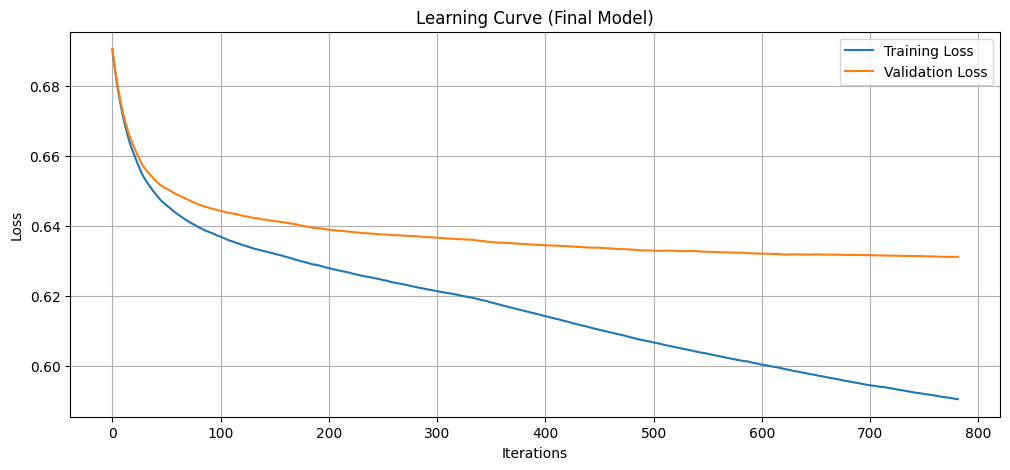

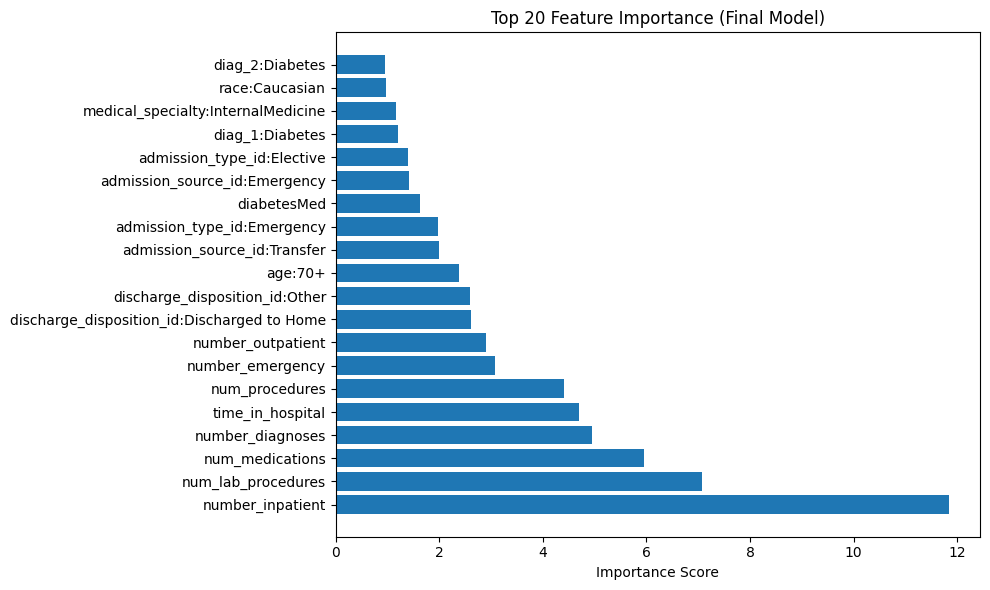

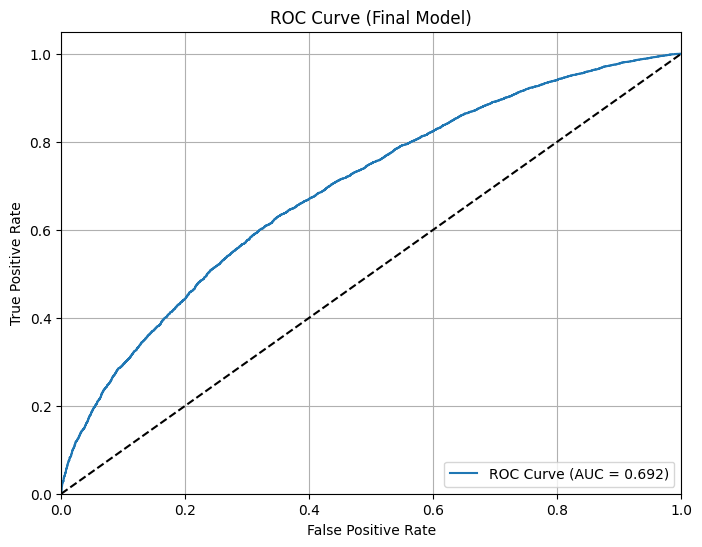

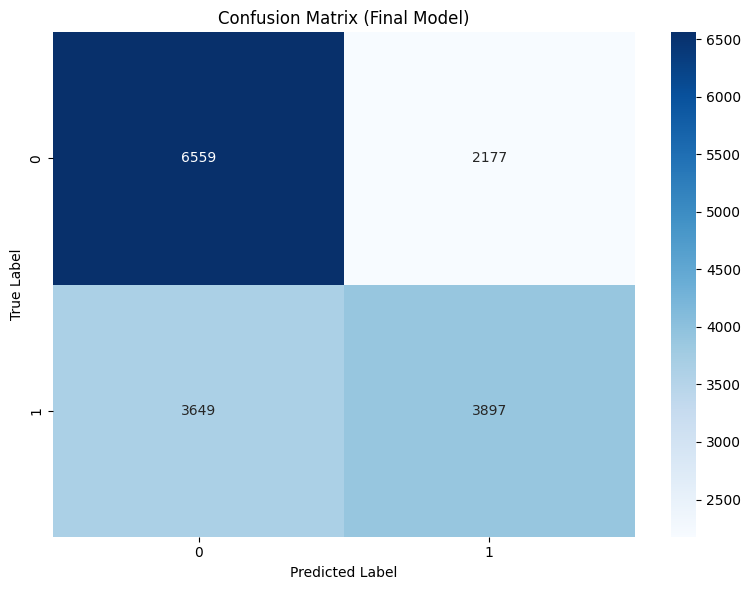

In [12]:
# Now evaluate the final model
evaluator = FinalModelEvaluator(
    model=final_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    cat_features=cat_features
)

# Run all evaluations
evaluator.evaluate_all()


In [13]:
os.makedirs('saved_models', exist_ok=True)
final_model.save_model('saved_models/Bayesian_Opt_Catboost.cbm')